# Analysis of the Models

In this document, we will look at various models, their explainability and evaluation.

## Importing the Data

We import the prepared data from the notebook [data_analysis.ipynb](./data_analysis.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
from lib.utils import get_X_y
import numpy as np
import seaborn as sns
import  matplotlib.pyplot as plt


from lib.load_dataset import get_ready_data

sns.set_theme()

# Unpickle the data
data_ready = get_ready_data(which="2019-2021")

# Drop records which were algorithmically filtered
ALGO_FILTER_COLUMN = "AlgoFiltered"
if ALGO_FILTER_COLUMN in data_ready.columns:
    data_ready = data_ready[data_ready[ALGO_FILTER_COLUMN] == 0]
    data_ready = data_ready.drop(columns=ALGO_FILTER_COLUMN)


TAKE_RANGE = (2, 3)

data_ready = data_ready[
    (data_ready["RecordCount"] >= TAKE_RANGE[0])
    & (data_ready["RecordCount"] <= TAKE_RANGE[1])
]


X, y = get_X_y(lambda: data_ready)

In [3]:
from lib.utils import pretty_print_columns_notebook

pretty_print_columns_notebook(data_ready)

## The Models

In this section, we look at the models.

### Help Functions

In [13]:
# Defining helper functions for model analysis
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

from lib.eval import evaluate_model

### XGB

In [8]:
# Import XGBoost
import xgboost as xgb

# Parameters for XGBoost
# fmt: off
XGB_HYPERPARAMS = {
    "objective": "binary:logistic",
    "enable_categorical": False,

    "n_estimators": 100,
    "max_depth": 7,
    "learning_rate": 0.1,
    "random_state": 42,
    "gamma": 0,
    "min_child_weight": 1,
    
    # The ratio of negative and positive values
    # "scale_pos_weight": y_val.value_counts()[0] / y_val.value_counts()[1],
}
# fmt: on


xgbc = xgb.XGBClassifier(**XGB_HYPERPARAMS)

#### CV

In [23]:
from typing import Any
from lib.eval import cross_val_non_merged_df


def do_cross_val(model: Any, scaler: Any = None) -> None:
    """
    Perform cross-validation on the model with the given scaler.
    """

    to_drop = ["PatientId", "RecordId"]
    X_columns_no_ids = X.columns.drop(to_drop)
    X_cv = X[X_columns_no_ids]

    return cross_val_non_merged_df(
        model,
        X_cv,
        y,
        n=TAKE_RANGE[1],
        groups=X["PatientId"],
        random_state=40,
        each_record_eval=True,
        confusion_matrix_plot=True,
        scaler=scaler,
    )

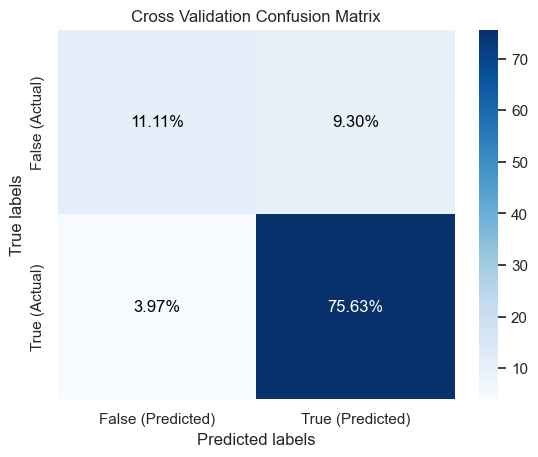

In [17]:
xgb_scores, xgb_each_record_scores = do_cross_val(xgbc)

In [18]:
from lib.eval import process_scoring_dict

print(process_scoring_dict(xgb_scores))

Test  : Accuracy       : 0.87 ± 0.005
Test  : F1             : 0.63 ± 0.013
Test  : Precision      : 0.74 ± 0.018
Test  : Recall         : 0.54 ± 0.015
Test  : Roc_auc        : 0.89 ± 0.007
Train : Accuracy       : 0.90 ± 0.002
Train : F1             : 0.73 ± 0.007
Train : Precision      : 0.84 ± 0.004
Train : Recall         : 0.65 ± 0.009
Train : Roc_auc        : 0.95 ± 0.001


In [19]:
from lib.eval import process_each_records_scores

print(process_each_records_scores(xgb_each_record_scores))

Group 2
Test  : Accuracy       : 0.87 ± 0.005
Test  : F1             : 0.62 ± 0.015
Test  : Precision      : 0.73 ± 0.024
Test  : Recall         : 0.53 ± 0.016
Test  : Roc_auc        : 0.89 ± 0.008
Train : Accuracy       : 0.90 ± 0.002
Train : F1             : 0.72 ± 0.007
Train : Precision      : 0.84 ± 0.006
Train : Recall         : 0.63 ± 0.010
Train : Roc_auc        : 0.95 ± 0.001
---
Group 3
Test  : Accuracy       : 0.86 ± 0.008
Test  : F1             : 0.67 ± 0.027
Test  : Precision      : 0.75 ± 0.042
Test  : Recall         : 0.60 ± 0.021
Test  : Roc_auc        : 0.90 ± 0.011
Train : Accuracy       : 0.91 ± 0.003
Train : F1             : 0.77 ± 0.010
Train : Precision      : 0.86 ± 0.005
Train : Recall         : 0.71 ± 0.014
Train : Roc_auc        : 0.96 ± 0.003
---



### Logistic Regression

In [15]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression(random_state=42, solver="liblinear")

standard_scaler = StandardScaler()
standard_scaler.fit(X)


# Standardize the data
def scaled_df(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(
        standard_scaler.transform(df), columns=df.columns, index=df.index
    )

#### CV

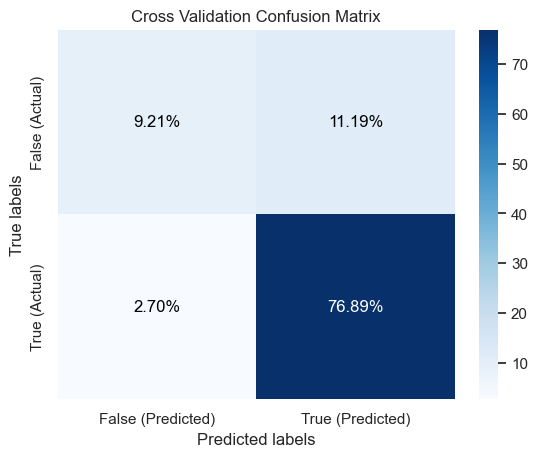

In [28]:
from sklearn.preprocessing import StandardScaler

lr_scores, lr_each_record_scores = do_cross_val(lr, scaler=StandardScaler())

In [29]:
from lib.eval import process_scoring_dict

print(process_scoring_dict(lr_scores))

Test  : Accuracy       : 0.86 ± 0.004
Test  : F1             : 0.57 ± 0.013
Test  : Precision      : 0.77 ± 0.006
Test  : Recall         : 0.45 ± 0.015
Test  : Roc_auc        : 0.85 ± 0.009
Train : Accuracy       : 0.86 ± 0.001
Train : F1             : 0.57 ± 0.003
Train : Precision      : 0.77 ± 0.003
Train : Recall         : 0.45 ± 0.003
Train : Roc_auc        : 0.85 ± 0.002


In [44]:
from lib.eval import process_each_records_scores

print(process_each_records_scores(lr_each_record_scores))

Group 2
Test  : Accuracy       : 0.86 ± 0.004
Test  : F1             : 0.55 ± 0.017
Test  : Precision      : 0.77 ± 0.016
Test  : Recall         : 0.43 ± 0.018
Test  : Roc_auc        : 0.84 ± 0.011
Train : Accuracy       : 0.86 ± 0.001
Train : F1             : 0.55 ± 0.004
Train : Precision      : 0.77 ± 0.006
Train : Recall         : 0.43 ± 0.004
Train : Roc_auc        : 0.84 ± 0.003
---
Group 3
Test  : Accuracy       : 0.86 ± 0.009
Test  : F1             : 0.66 ± 0.032
Test  : Precision      : 0.78 ± 0.036
Test  : Recall         : 0.57 ± 0.032
Test  : Roc_auc        : 0.87 ± 0.007
Train : Accuracy       : 0.87 ± 0.002
Train : F1             : 0.67 ± 0.008
Train : Precision      : 0.79 ± 0.009
Train : Recall         : 0.58 ± 0.008
Train : Roc_auc        : 0.87 ± 0.002
---



#### Explanation

In [35]:
def explain_vars_regression(model, columns: list[str]) -> pd.DataFrame:
    """
    Get the weights of the model.
    Parameters:

    """

    return (
        pd.DataFrame({"feature": columns, "weight": model.coef_[0]})
        .sort_values(by="weight", ascending=False)
        .reset_index(drop=True)
    )

In [37]:
from IPython.display import display

lr.fit(scaled_df(X), y)
lr_explained = explain_vars_regression(lr, X.columns)

display(lr_explained.head(10))
display(lr_explained.tail(10))

,feature,weight
0,ClinicalStadium,0.512300
1,TypeOfCare,0.311638
2,T,0.281659
3,CodeEstablishingDg,0.240158
4,Topography,0.197657
5,RecordId,0.176795
6,NoveltyRank,0.169997
7,PNExamination,0.139001
8,MorphHistology,0.087392
9,ICDLoc,0.049074


,feature,weight
17,SentinelLymphNode,-0.033031
18,CreatedWithBatch,-0.048981
19,PNExaminationPos,-0.055658
20,MorphGrading,-0.060336
21,UnknownCount,-0.067532
22,N,-0.127366
23,MorphBehavior,-0.164886
24,YearDg,-0.184293
25,ICD,-0.335919
26,ICDRangeC76-C80,-0.682678


<Axes: xlabel='Feature', ylabel='Weight'>

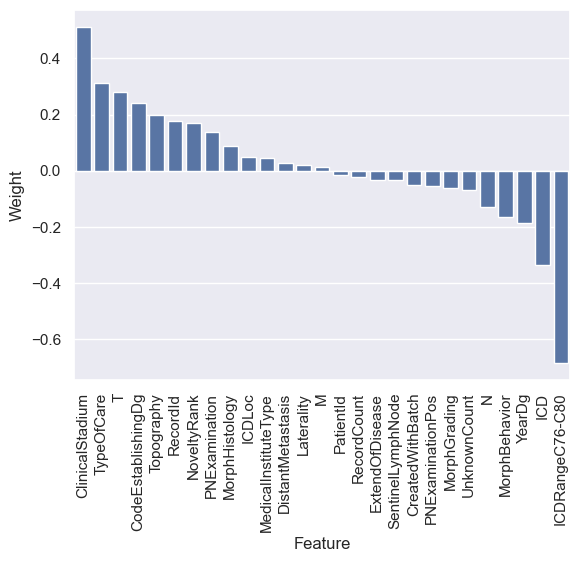

In [38]:
_, ax = plt.subplots()

ax.tick_params(axis="x", labelrotation=90)
ax.set_xlabel("Feature")
ax.set_ylabel("Weight")

sns.barplot(lr_explained, x="feature", y="weight")

### Only Positive Classifier
The following classifier constantly classifies every entry as `1`.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from lib.eval import evaluate_model


class OnlyPositiveClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        super().__init__()
        self.classes_ = [0, 1]
        self.decision_function = self.predict_proba

    def fit(self, X, y):
        pass

    def ones(self, X):
        return np.ones(X.shape[0])

    def predict(self, X):
        return self.ones(X)

    def predict_proba(self, X):
        # Two dimensional array with zeros on first column and ones on the second
        n = X.shape[0]
        return np.column_stack((np.zeros(n), np.ones(n)))


opc = OnlyPositiveClassifier()
opc.fit(X, y)

evaluate_model(
    opc,
    names_datasets_trues=[
        ("Whole Dataset", X, y),
    ],
    groups=X["PatientId"],
    use_cross_val=False,
    # filename="./logs/only_positive_classifier_one_entry.txt",
)

## XGB Explanation

### SHAP

In [20]:
import shap

shap.initjs()

#### Summary Plot

[20:59:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


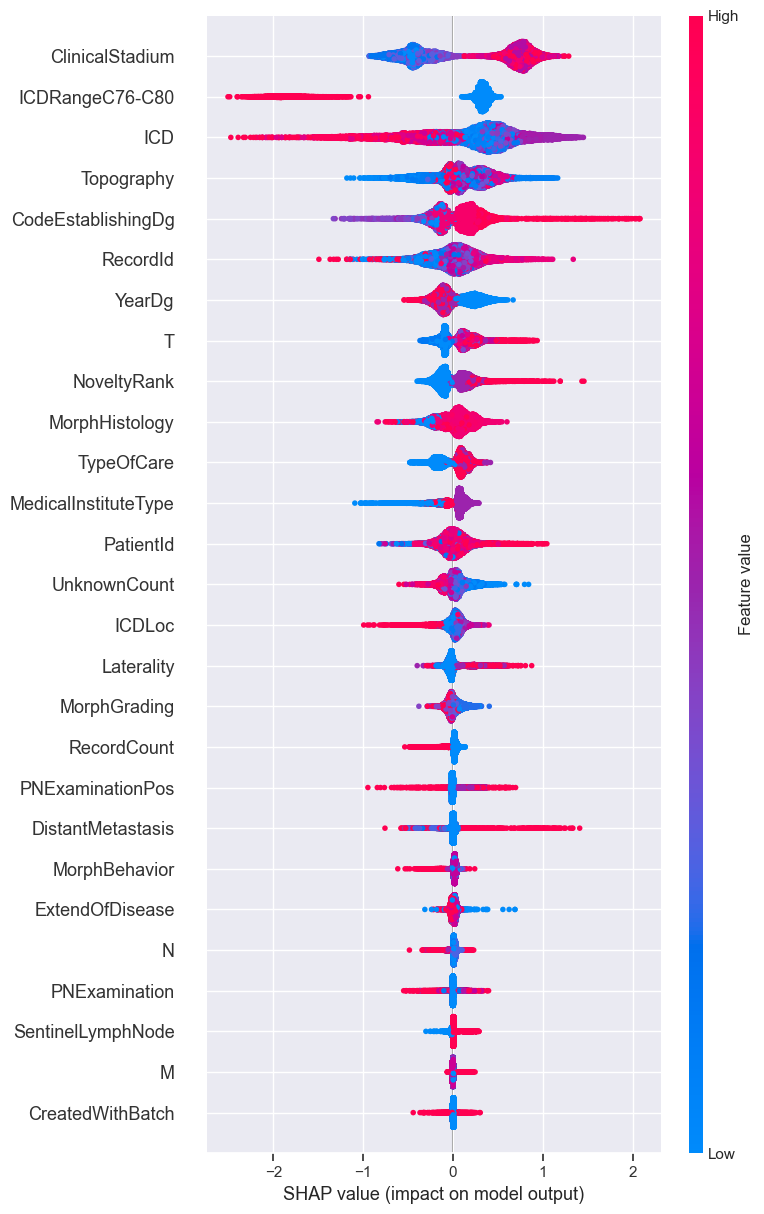

In [21]:
import xgboost as xgb

xgbc_shap = xgb.XGBClassifier(**XGB_HYPERPARAMS)
xgbc_shap.fit(X, y)

explainer = shap.TreeExplainer(xgbc_shap)
# Calculate shap values
shap_values = explainer(X)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X, max_display=30)

#### DgKod_Encoded

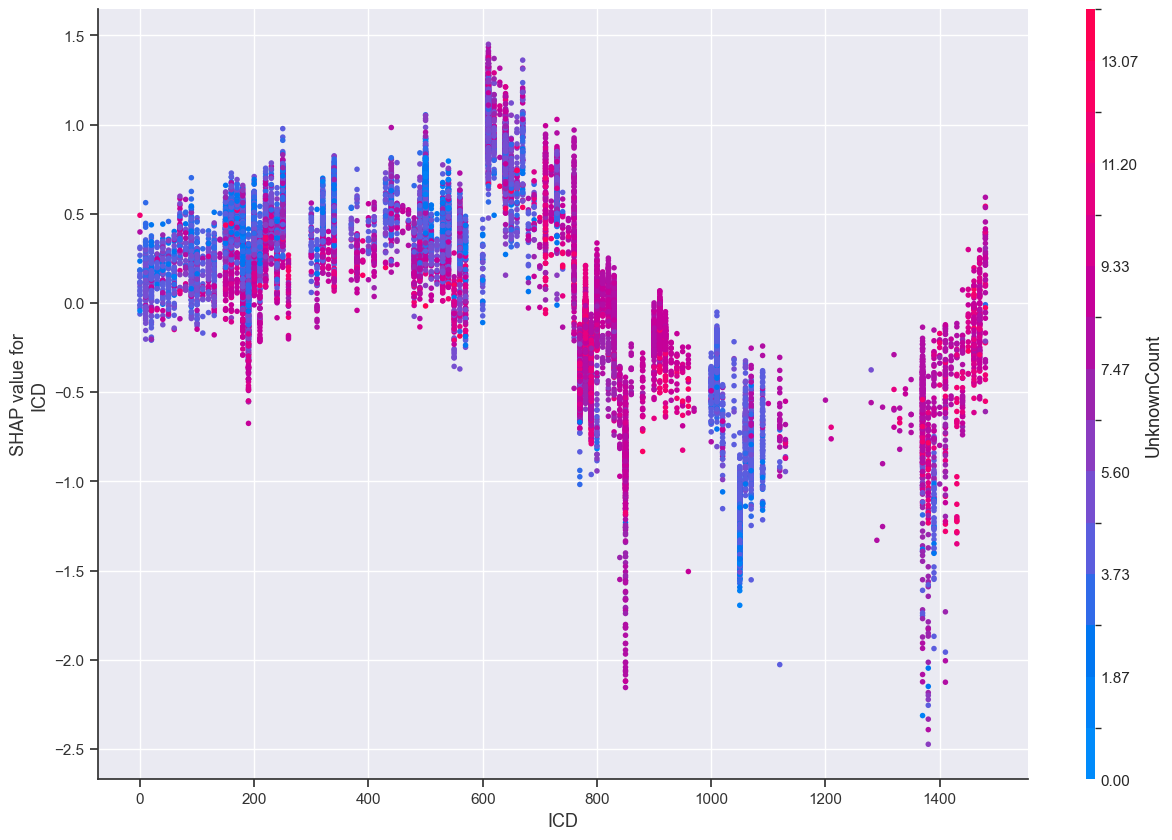

In [10]:
_, ax = plt.subplots(figsize=(15, 10))

shap.dependence_plot("ICD", shap_values.values, X, ax=ax)

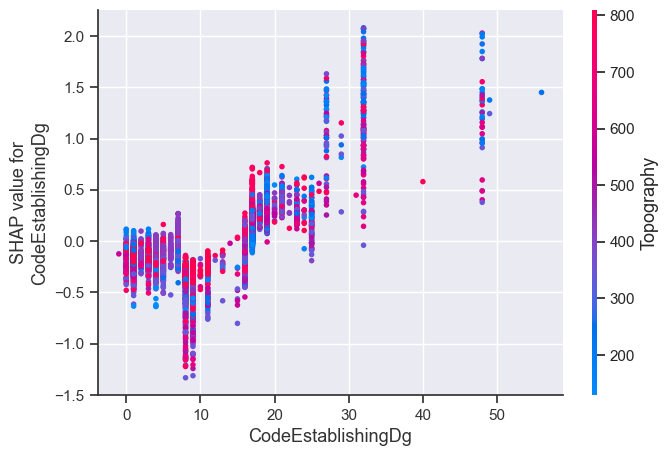

In [55]:
shap.dependence_plot("CodeEstablishingDg", shap_values.values, X)

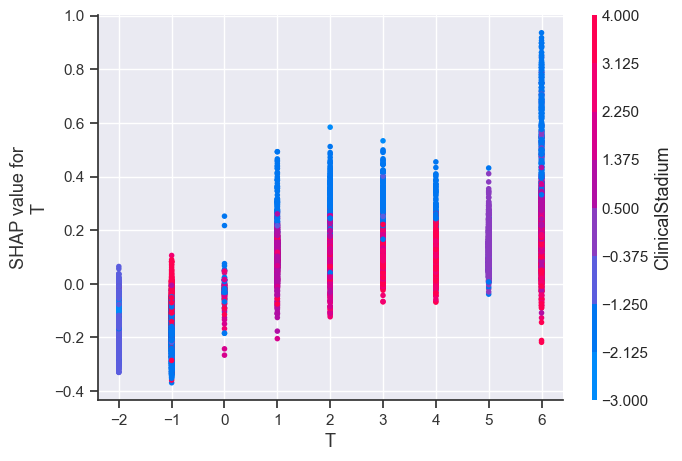

In [56]:
shap.dependence_plot("T", shap_values.values, X)

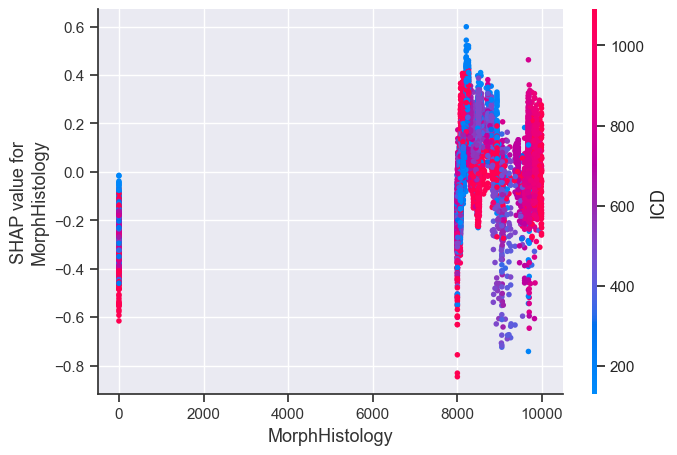

In [57]:
shap.dependence_plot("MorphHistology", shap_values.values, X)

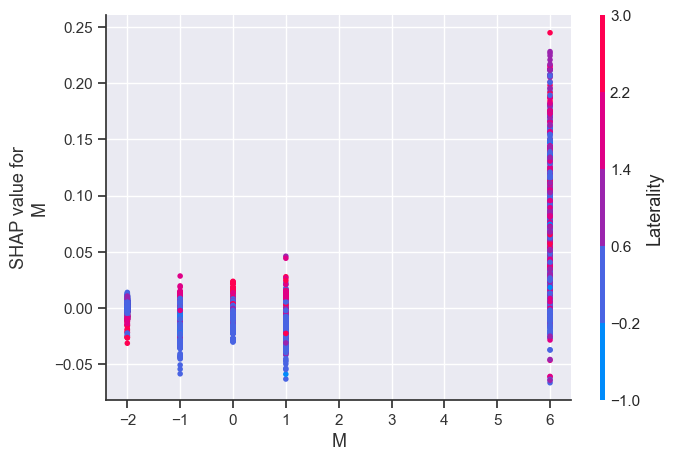

In [58]:
shap.dependence_plot("M", shap_values.values, X)

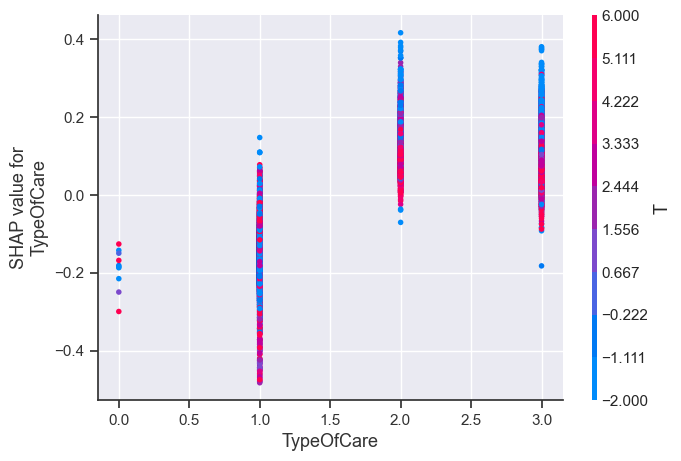

In [59]:
shap.dependence_plot("TypeOfCare", shap_values.values, X)

#### Waterfall Plots

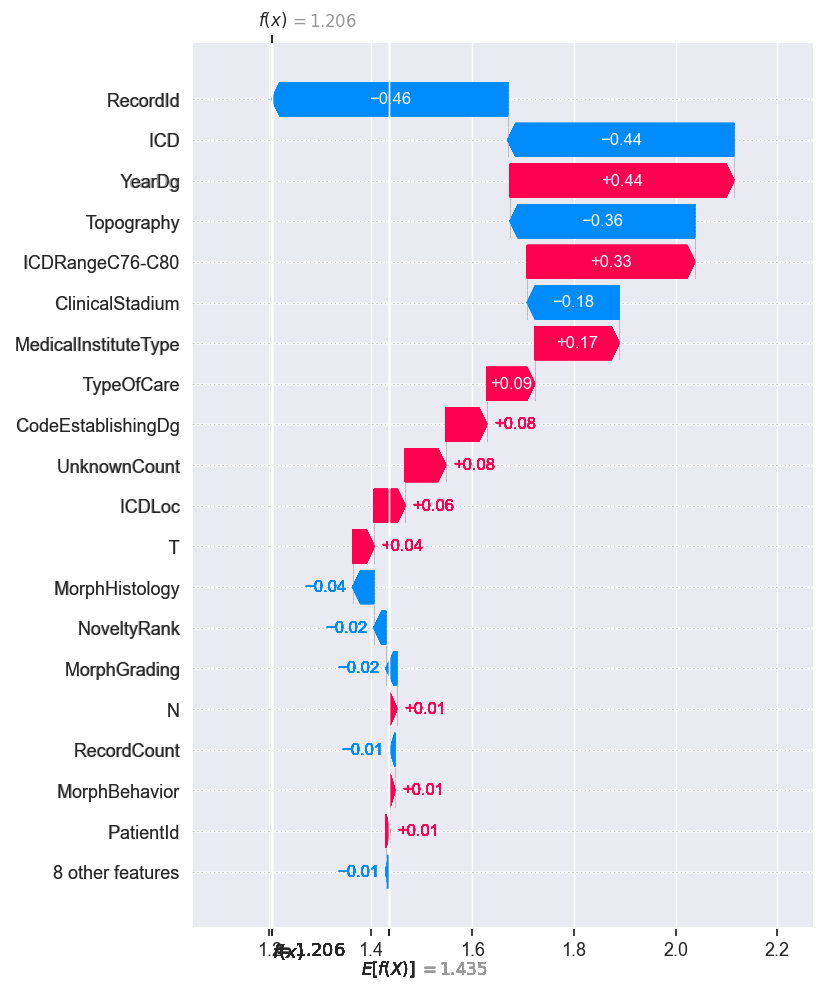

In [41]:
index = 30 + 3
shap.plots.waterfall(shap_values[index], max_display=20, show=False)
ax = plt.gca()

renamed_labels = []
for txt in ax.get_yticklabels():
    if "=" not in txt.get_text():
        renamed_labels.append(txt.get_text())
    else:
        renamed_labels.append(txt.get_text().split(" = ")[1])

ax.set_yticklabels(renamed_labels)
plt.show()

## Verification on New Records

In [11]:
from lib.utils import drop_ids
from lib.load_dataset import get_ready_data
from lib.utils import get_X_y


X_train = drop_ids(X.copy())
y_train = y.copy()


def getter_test():
    out = get_ready_data(which="verify_dataset")
    out = out[out[ALGO_FILTER_COLUMN] == 0]
    out = out[out["RecordCount"].between(*TAKE_RANGE)]
    out.drop(columns=ALGO_FILTER_COLUMN, inplace=True)
    return out


X_test, y_test = get_X_y(getter_test)
X_test = drop_ids(X_test)

### XGB

22/05/2024 20:57:39
Evaluations

Accuracy:
Train: 89.8483 %
Test: 87.3835 %

F1 Score:
Train: 0.718
Test: 0.599

Precision:
Train: 0.828
Test: 0.681

Recall:
Train: 0.634
Test: 0.534

AUC:
Train: 0.947
Test: 0.87

Validation dataset confusion matrix:
Validation dataset not found

Confusion matrices (plots):


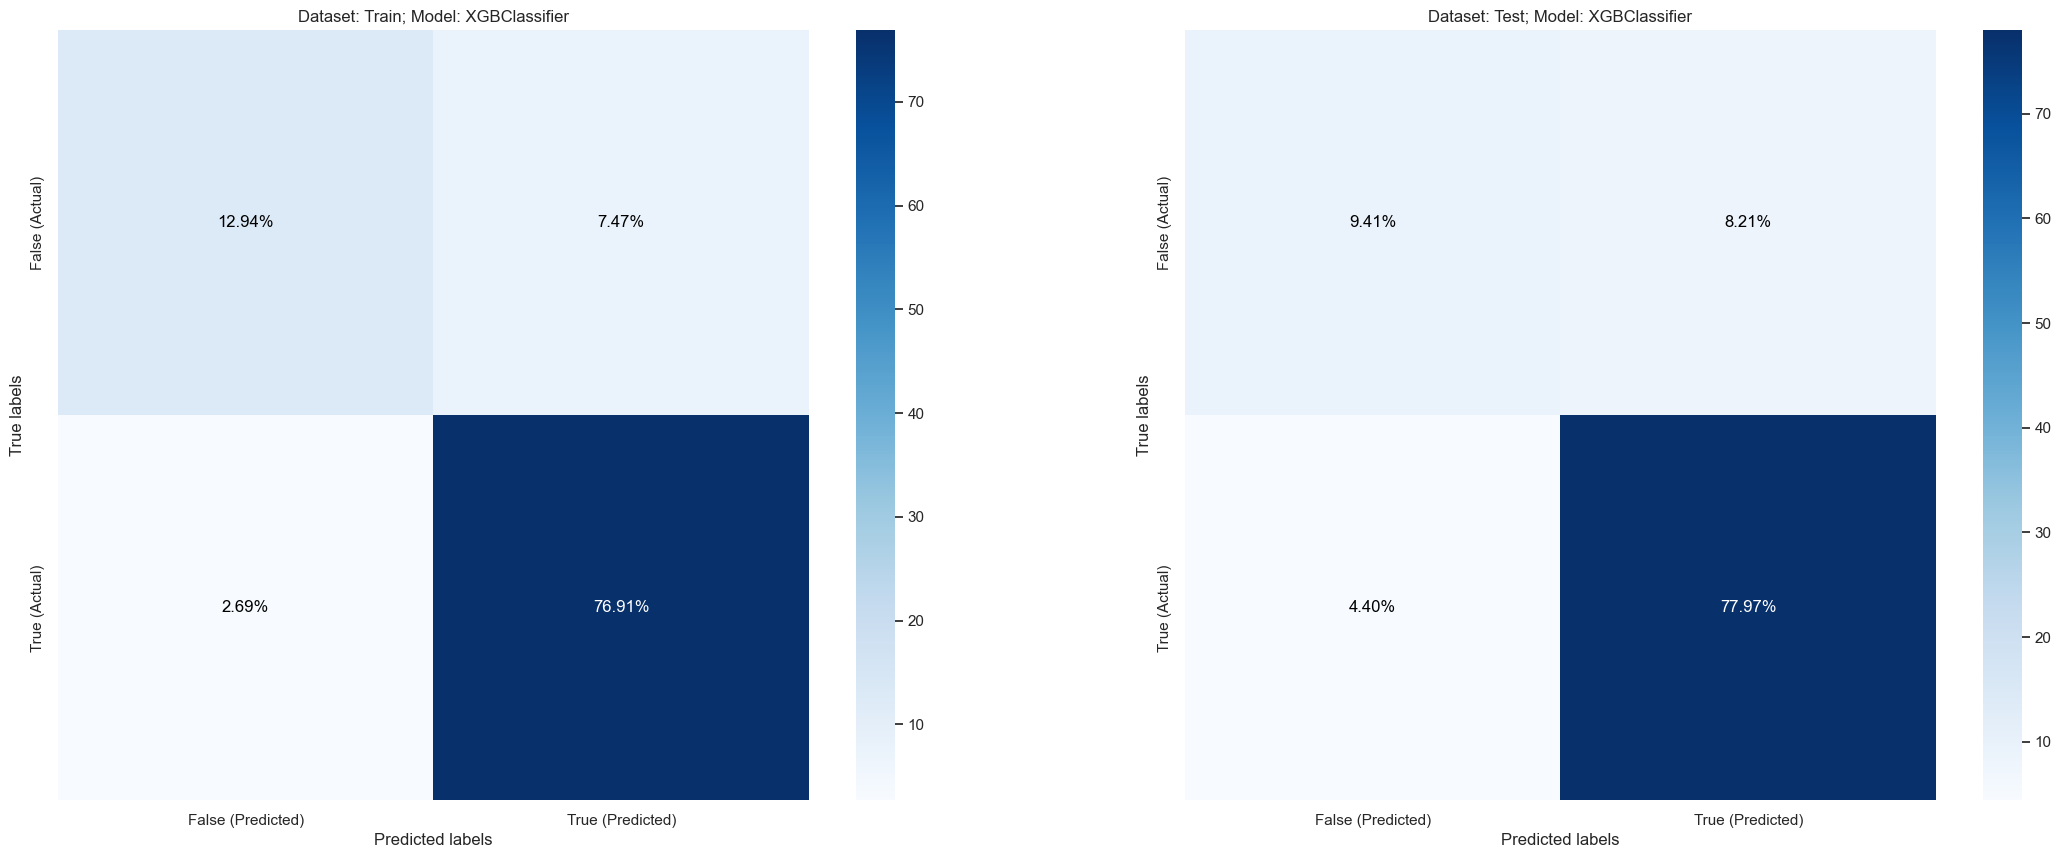

In [12]:
from lib.eval import evaluate_model


# Train the model
xgbc.fit(X_train, y_train)
y_pred = pd.Series(xgbc.predict(X_test))
y_score = pd.Series(xgbc.predict_proba(X_test)[:, 1])

# Evaluate the model
evaluate_model(
    xgbc,
    [
        ("Train", X_train, y_train),
        ("Test", X_test, y_test),
    ],
)

In [13]:
from lib.eval import evaluate_by_report_count, process_each_records_scores

scores = evaluate_by_report_count(
    X_test.reset_index(drop=True),
    y_test.reset_index(drop=True),
    y_pred,
    TAKE_RANGE,
    record_count_getter=lambda df: df["RecordCount"],
    y_score=y_score,
)

for i in scores.keys():
    print("Group", i)
    for k, v in scores[i].items():
        print(f"{k}: {round(v, 3)}")

Group 2
test_accuracy: 0.875
test_f1: 0.59
test_precision: 0.67
test_recall: 0.528
test_roc_auc: 0.869
Group 3
test_accuracy: 0.864
test_f1: 0.645
test_precision: 0.749
test_recall: 0.567
test_roc_auc: 0.874


### LR

22/05/2024 20:58:29
Evaluations

Accuracy:
Train: 78.2786 %
Test: 80.3482 %

F1 Score:
Train: 0.281
Test: 0.228

Precision:
Train: 0.433
Test: 0.37

Recall:
Train: 0.208
Test: 0.164

AUC:
Train: 0.573
Test: 0.555

Validation dataset confusion matrix:
Validation dataset not found

Confusion matrices (plots):


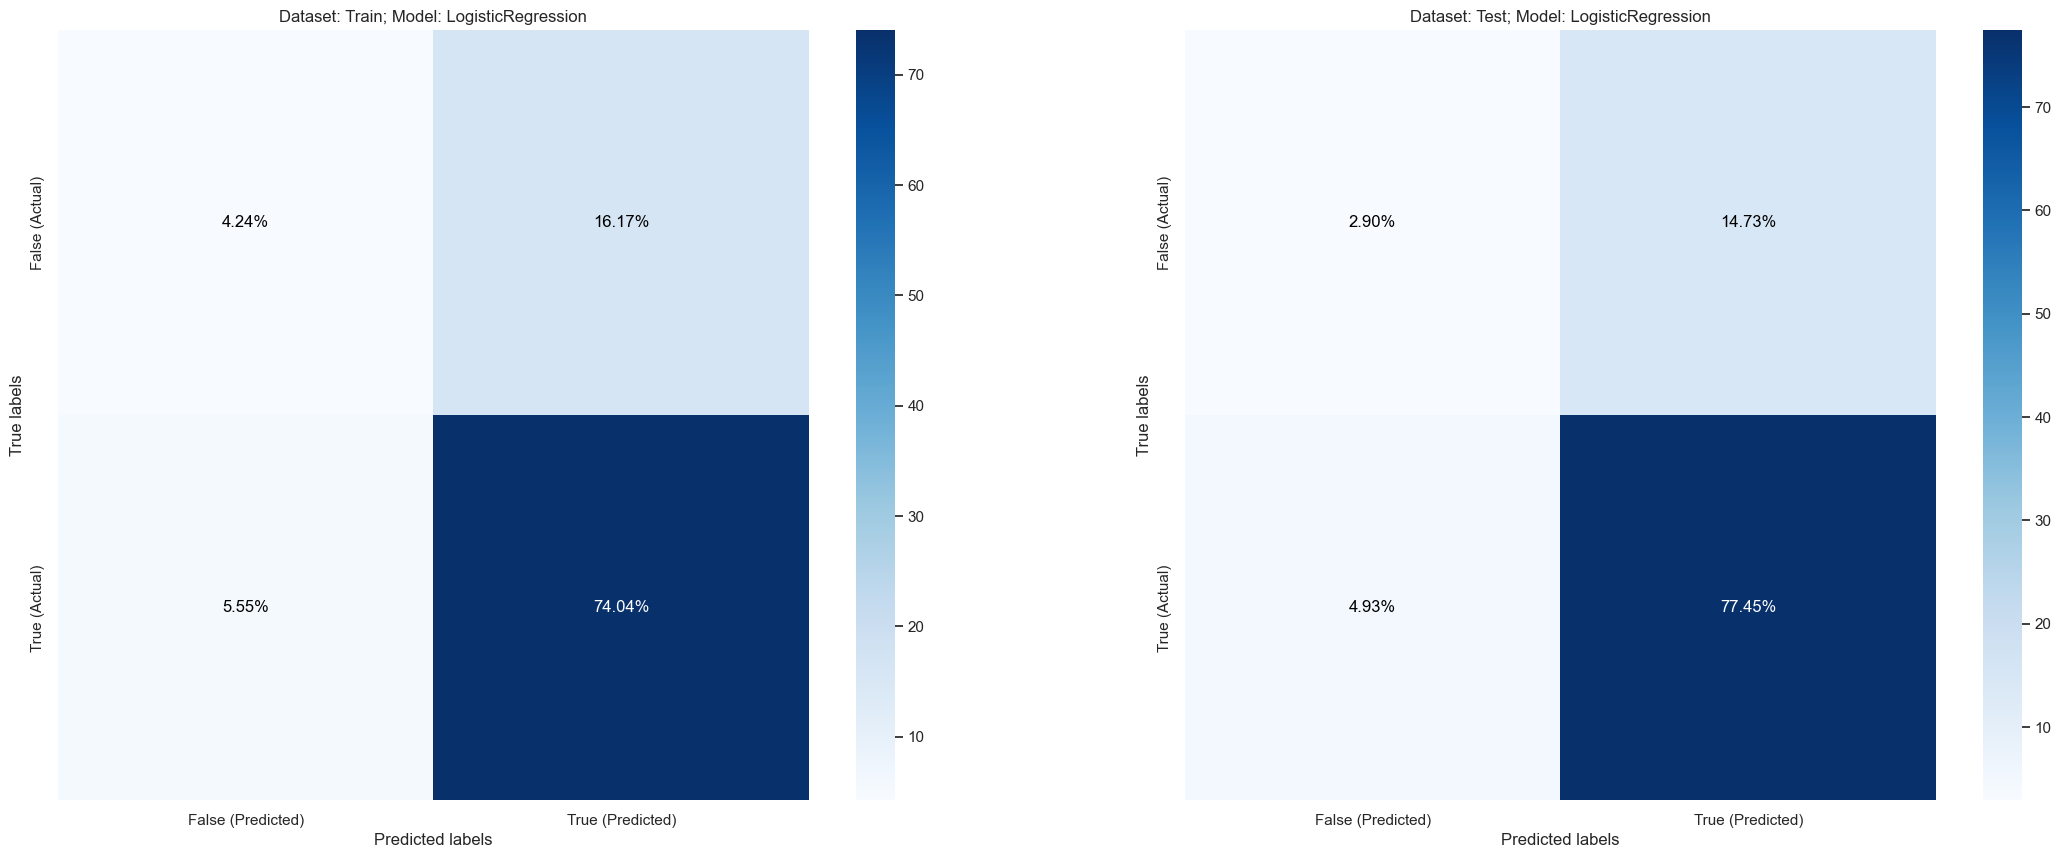

In [17]:
from lib.eval import evaluate_model


# Train the model
standard_scaler.fit(X_train)
lr.fit(scaled_df(X_train), y_train)
y_pred = pd.Series(lr.predict(X_test))
y_score = pd.Series(lr.predict_proba(X_test)[:, 1])

# Evaluate the model
evaluate_model(
    lr,
    [
        ("Train", X_train, y_train),
        ("Test", X_test, y_test),
    ],
)

In [19]:
from lib.eval import evaluate_by_report_count

scores = evaluate_by_report_count(
    X_test.reset_index(drop=True),
    y_test.reset_index(drop=True),
    y_pred,
    TAKE_RANGE,
    record_count_getter=lambda df: df["RecordCount"],
    y_score=y_score,
)

for i in scores.keys():
    print("Group", i)
    for k, v in scores[i].items():
        print(f"{k}: {round(v, 3)}")

Group 2
test_accuracy: 0.807
test_f1: 0.203
test_precision: 0.341
test_recall: 0.144
test_roc_auc: 0.545
Group 3
test_accuracy: 0.78
test_f1: 0.354
test_precision: 0.49
test_recall: 0.278
test_roc_auc: 0.604
